<a href="https://colab.research.google.com/github/pgupta7/Company_review_analysis/blob/main/Company_reviews.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<font color = 'blue'>
In this project, we will analyze the reviews given to various companies by their employees. We will use the text of the reviews and create models to determine the rating score from the text. The data consists of two columns, one with review text and the other with ratings in it. <br><br>
Since the project is about unsupervised learning, we will primarily create unsupervised learning models to make predictions. Finally, we will use the provided ratings as a test for the fitness of our models' predictions.<br>
I took the data from the following source:
<a>https://www.kaggle.com/competitions/sentiment-analysis-company-reviews/overview</a>.<br>
Besides, I have uploaded this notebook in a public github repository at the following address: <a>https://github.com/pgupta7/Company_review_analysis</a>

<font color = 'blue'>
Downloading the data from the source website

In [ ]:
company_reviews_path = kagglehub.competition_download('sentiment-analysis-company-reviews')

print('Data source import complete.')

Data source import complete.


<font color = 'blue'>
Importing the necessary libraries.

In [ ]:
import pandas as pd
import numpy as np
import itertools as itr
import matplotlib.pyplot as plt
import tensorflow as tf

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn.decomposition import NMF, TruncatedSVD
import itertools as itr
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.utils import resample

from sklearn.cluster import AgglomerativeClustering
from sklearn.model_selection import GridSearchCV
from tqdm import tqdm

In [ ]:
os.listdir(company_reviews_path)

['train.csv', 'sample_submission.csv', 'test.csv']

In [ ]:
train_df = pd.read_csv(company_reviews_path + '/train.csv')

## Exploratory data analysis

In [ ]:
train_df.head()

,Id,Review,Rating
0,0,Very good value and a great tv very happy and ...,5
1,1,After 6 month still can't access my account,3
2,2,I couldn't make an official review on a produc...,1
3,3,"Fantastic! Extremely easy to use website, fant...",5
4,4,So far annoyed as hell with this bt monthly pa...,1


In [ ]:
train_df.shape

(60000, 3)

<font color = 'blue'>
We have 60000 reviews on which we can train and test the models.

<font color = 'blue'>
Checking the distribution of ratings.

In [ ]:
train_df['Rating'].value_counts()

,count
Rating,
5,34679
1,18663
4,3350
3,1679
2,1629


<Axes: >

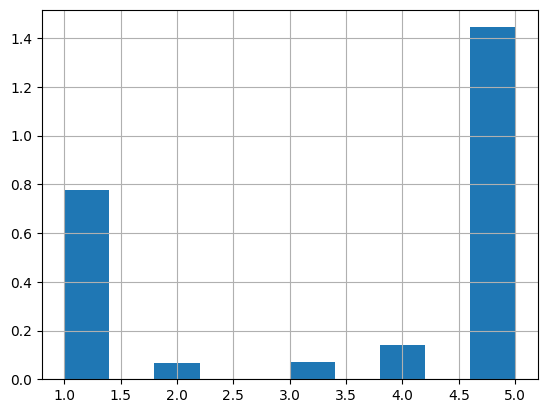

In [ ]:
train_df['Rating'].hist(density = True)

<font color ='blue'>
Since the dataset is skewed with more reviews being either 5 star and 1 star, and very few being in the middle, we will use F1 score in addition to accuracy as our metrics. The F1 score is suitable to capture the goodness of prediction of the low frequency labels.

<font color = 'blue'>
Checking for NANs.

In [ ]:
train_df.isna().sum()

,0
Id,0
Review,0
Rating,0


## Data cleaning

<font color = 'blue'>
Downloading the necessary libraries for the data cleaning.

In [ ]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer

# need to unzip the wordnet manually after this
!unzip /root/nltk_data/corpora/wordnet.zip -d /root/nltk_data/corpora/

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Archive:  /root/nltk_data/corpora/wordnet.zip
replace /root/nltk_data/corpora/wordnet/lexnames? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

<font color = 'blue'>
Next, we will clean the review texts and make them appropriate for data analysis.
First, we will convert all the text to lowercase, as the case of the letters should be immaterial to the content. Next, remove any urls, if they are present, although unlikely in reviews. Lastly, we will remove any special characters from the reviews.

In [ ]:
import re
def cleanText(text):
    # lower-casing the text
    text = text.lower()
    # clean for any url
    text = re.sub('https:\S+|http:\S+|www.\S+', '',text)
    # clean for any special characters
    text = re.sub('[^a-zA-z\s]','', text)
    return text

<font color = 'blue'>
Next, we will remove any stopwords from the review text, i.e., common use words like personal pronous(I, we, us, etc.) and supportive verbs (is, am, would, etc.). We will also lemmatize the text, meaning we will reduce different forms of a word to the root word. For example, we will eliminate the singulars and plurals with the singular form.
The process of removing the stopwords and lemmatization reduces the size of the reviews by removing words which likely do not help with classification.

In [ ]:
stpwrds = set(stopwords.words('english'))
# Declaring a lammatizer.
lemmatizer = WordNetLemmatizer()
def lemmatizeText(text):
    # Lemmatizing the text
    words = text.split()
    words = [lemmatizer.lemmatize(x) for x in words if x not in stpwrds]
    return ' '.join(words)

<font color = 'blue'>
Given the constraint of the RAM, the available computing power, and the time for the project, we will use 3000 reviews from the dataset to make predictions and training. I tried with more reviews, but the system became significantly slow for higher values, so I had to settle down with 3000.

In [ ]:
train_df = train_df.sample(n = 3000).reset_index(drop=True)
X = train_df['Review']
# Cleaning and Lemmatizing the text.
X = list(map(lambda x: cleanText(x), X))
X = list(map(lambda x: lemmatizeText(x), X))
X = np.array(X)
y = np.array(train_df['Rating'])

## Vectorization

<font color = 'blue'>
Before we perform an analysis to determine the categories of the entities in the dataset, we must express the words in each of the entities as numerics, or in the language of NLP, we will perform word embeddings.<br><br>
Below, I use the TF-IFD vectorizer to create a matrix form of word embeddings. A TF-IFD vector balances term frequency (TF) and inverse document frequency (IFD) to provide a numeric value. Term frequency of a given word within a document is defined by the number of instances of the word as a fraction of total number of words in the document. TF has potential to inflate the importance of common words like 'the', 'of', etc., which aren't much useful in categorizing a document. Hence, the vectrorizer uses IDF to compensate for this issue. IDF computes the inverse frequency of a given word accross multiple documents, thus increasing the weight of rare words accross documents while decreaing the importance of common words accross documents, for example, 'the', 'of', etc., which are common across documents, get deemphasized. The TF-IFD value of a given word is given by TF * IFD.

In [ ]:
# Creating the vectorizer
vectorizer = TfidfVectorizer(stop_words="english", max_features= None).fit(X)

In [ ]:
# Transforming the data
X = vectorizer.transform(X).toarray()

In [ ]:
X.shape

(3000, 6652)

<font color = 'blue'>
Plotting all the values of the vectorized dataset to check for the distribution of values.

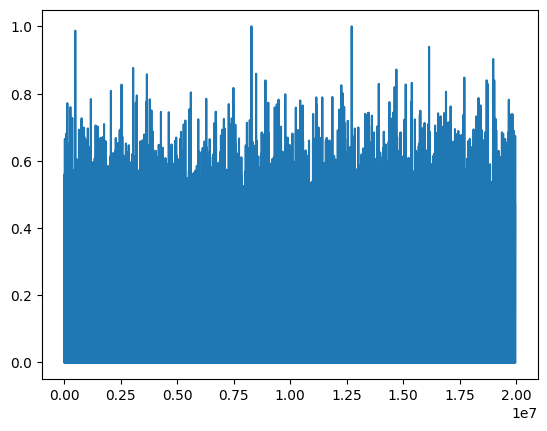

In [ ]:
plt.plot(X.flatten())

<font color = 'blue'>
The above plot of all the values of X shows that it has a hard minimum bound at 0, with numbers reaching upto 1. This will have consequences in what methods we choose in subsequent sections for data analysis.

<font color = 'blue'>
Splitting the data into a training and a test dataset.

In [ ]:
# Test-train split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
X_train.shape

(2100, 6652)

<font color = 'blue'>
Checking the disctribution of both the train and the test set.

(array([0.76388889, 0.        , 0.06666667, 0.        , 0.        ,
        0.07777778, 0.        , 0.13055556, 0.        , 1.46111111]),
 array([1. , 1.4, 1.8, 2.2, 2.6, 3. , 3.4, 3.8, 4.2, 4.6, 5. ]),
 <BarContainer object of 10 artists>)

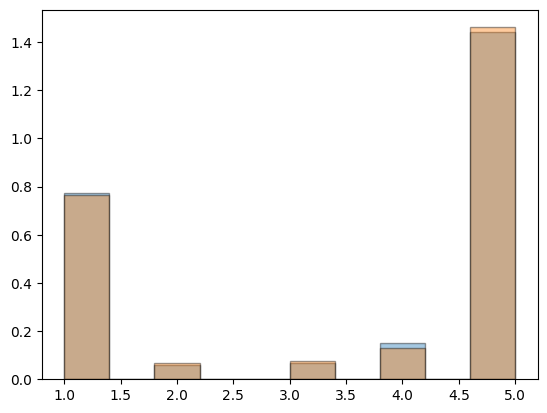

In [ ]:
plt.hist(y_train, edgecolor = 'black', alpha = 0.4, density = True)
plt.hist(y_test, edgecolor = 'black', alpha = 0.4, density = True)

#Models

## Non-negative matrix factorization(NMF)

<font color = 'blue'>
Since the matrix X is a non-negative one, we will use the method of non-negative matrix factorization to model the data. We will factor the matrix X into two matrices W and H. The W matrix will have equal number of rows as X, but will only have 5 columns. We choose 5 columns to represent them as the 5 ratings we have.

<font color = 'blue'>
Furthermore, since our training data is disctributed with low positive values, we will use kullback-leibler as our beta loss while solving for the matrix factors. The kullback-leibler loss treats the values as poisson distributed and thus avoids negative numbers during the fit.

In [ ]:
nmf = NMF(n_components= 5, beta_loss= 'kullback-leibler', solver = 'mu', alpha_W= 0.3, alpha_H = 0.3).fit(X_train)

In [ ]:
w_train = nmf.transform(X_train)
w_test = nmf.transform(X_test)

<font color = 'blue'>
We take the index of the maximum value along a row as the predicted rating for a given row of X, which represents a particular review.

In [ ]:
y_train_pred = np.argmax(w_train, axis = 1)
y_test_pred = np.argmax(w_test, axis = 1)

<font color = 'blue'>
We note that the labels 1,2,3,4, and 5 provided by the model in the predicted values are arbitrary and bear no relation to the actuals values of rating in the dataset. We will have to identify the correct labels. To do so, we replace the labels in the predicted values with all the different combinations of the sequence of labels. The sequence of labels that gives the best accuracy for the predicted values would be the correct sequence of labels, in conformity to the actual ratings in the data.<br>
The below helper function, gettag, helps us do this. We will use this function on the predicted values of all the unsupervised learning models.

In [ ]:
def gettag(y_true, y_pred):
  # different permutations of the labels
  tags = list((itr.permutations(range(1, 6))))
  def calcacc(tag):
      pred = np.vectorize(lambda x: tag[x - 1])(y_pred)
      acc = accuracy_score(y_true, pred)
      return acc
  # iterating over all the different permutations of the labels.
  accs = list(map(calcacc, tags))
  ind = np.argmax(accs)
  return tags[ind]

In [ ]:
# getting the correct sequence of labels
tag = gettag(y_train, y_train_pred)
# Replacing the labels in the predicted values to the correct ones found in the previous line.
y_train_pred = np.vectorize(lambda x: tag[x - 1])(y_train_pred)
print('train accurcay:', accuracy_score(y_train, y_train_pred))
y_test_pred = np.vectorize(lambda x: tag[x - 1])(y_test_pred)
print('test accurcay:', accuracy_score(y_test, y_test_pred))

train accurcay: 0.6557142857142857
test accurcay: 0.7655555555555555


<font color = 'blue'>
Plot showing the distribuition of the true and the predicted ratings.

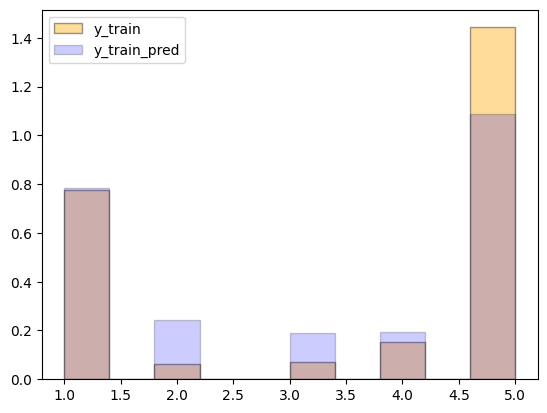

In [ ]:
plt.hist(y_train, label = 'y_train', density = True, color = 'orange',
           edgecolor = 'black', alpha = 0.4)
plt.hist(y_train_pred, label = 'y_train_pred',
           density = True, color = 'blue', edgecolor = 'black', alpha = 0.2)
plt.legend()

<font color = 'blue'>
We can see that the distribution of the predicted and the true values is quite different for the intermediate values of 2, 3, and 4 ratings, implying a possiblity of very low f1 score. We will calculate the F1 score below and check the actual numbers.

<font color = 'blue'>
A helper function to get the F1 scores on the predictions.<br>
The below function computes the F1 scores for each of the rating values, and then also computes the mean of all the F1 scores.

In [ ]:
def getF1Score(y_true, y_pred):
  # F1 score of each of the ratings.
  print('F1 score for rating 1,', f1_score(y_true == 1, y_pred == 1))
  print('F1 score for rating 2,', f1_score(y_true == 2, y_pred == 2))
  print('F1 score for rating 3,', f1_score(y_true == 3, y_pred == 3))
  print('F1 score for rating 4,', f1_score(y_true == 4, y_pred == 4))
  print('F1 score for rating 5,', f1_score(y_true == 5, y_pred == 5))
  # Mean F1 score for the prediction.
  print('Mean F1 score', f1_score(y_true, y_pred, average = 'macro'))

<font color = 'blue'>
We check the distribution of the true and the predicted values overlayed together, to check how their distributions differ.

In [ ]:
getF1Score(y_train, y_train_pred)

F1 score for rating 1, 0.8237986270022883
F1 score for rating 2, 0.0392156862745098
F1 score for rating 3, 0.03669724770642202
F1 score for rating 4, 0.1780821917808219
F1 score for rating 5, 0.7551789077212806
Mean F1 score 0.36659453209706455


<font color = 'blue'>
Low mean F1 score indicating a low prediction power for the ratings 2, 3, and 4, which are low in frequency in the datset.

## Grid search on NMF model to finetune hyperparameters

<font color = 'blue'>
Next, we will fine-tune some of the hyper-parameters of the NMF model, viz., alpha_W and alpha_H, which are the regularizers for the W and H matrices.<br>
We train the model on X_train and test it on X_test.

In [ ]:
alpha_W = [0, 0.5, 1, 1.5]
alpha_H = [0, 0.5, 1, 1.5]
accuracy = []
f1score = []

#Below, we train the model on X_train and test it on X_test.
for i, w in tqdm(enumerate(alpha_W), leave = True):
  for j, h in enumerate(alpha_H):
    # Creating the model
    nmf = NMF(n_components= 5, beta_loss= 'kullback-leibler', solver = 'mu', alpha_W= w, alpha_H = h).fit(X_train)
    # transforming the data
    w_test = nmf.transform(X_test)
    # predicting the results
    y_test_pred = np.argmax(w_test, axis = 1)
    # Correcting the labels in the predicted values, discussed earlier
    tag = gettag(y_test, y_test_pred)
    y_test_pred = np.vectorize(lambda x: tag[x - 1])(y_test_pred)
    # Computing the accurcay and F1 score.
    accuracy.append(accuracy_score(y_test, y_test_pred))
    f1score.append(f1_score(y_test, y_test_pred, average = 'macro'))
    print(accuracy[-1], f1score[-1], i, j)


0it [00:00, ?it/s]

0.49 0.30575399197266984 0 0
0.4311111111111111 0.2983721513321079 0 1
0.43222222222222223 0.2964362504522 0 2


1it [01:45, 105.02s/it]

0.4311111111111111 0.2998083805124561 0 3
0.5555555555555556 0.31134974206643096 1 0
0.7955555555555556 0.3698308142884555 1 1
0.7977777777777778 0.3520552112247614 1 2


2it [02:23, 65.73s/it] 

0.7933333333333333 0.33441512628756875 1 3
0.5533333333333333 0.31085561790252597 2 0
0.7977777777777778 0.3516936383360697 2 1
0.7944444444444444 0.3329627323808248 2 2


3it [03:05, 55.02s/it]

0.7977777777777778 0.33341923198984447 2 3
0.5544444444444444 0.31114917450675145 3 0
0.7933333333333333 0.3480378009789774 3 1
0.7977777777777778 0.33341923198984447 3 2


4it [03:46, 56.72s/it]

0.7866666666666666 0.3270451864389393 3 3


<font color = 'blue'>
Plotting the accuracies and the f1 scores over the grid of alpha_W and alpha_H values.

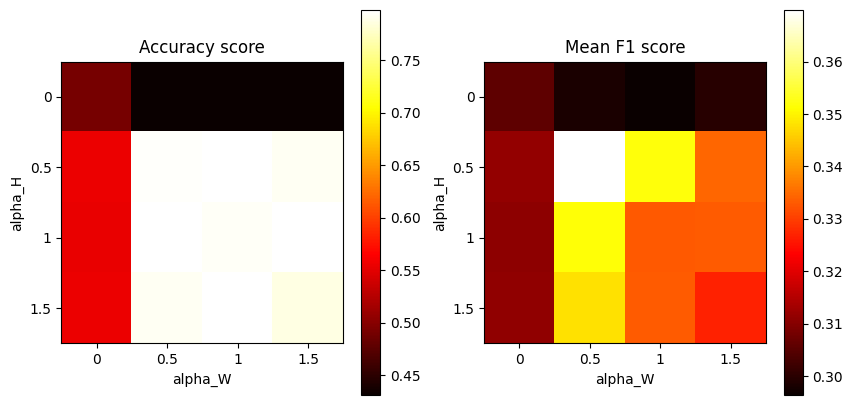

In [ ]:
accuracy = np.array(accuracy).reshape(len(alpha_W), len(alpha_H))
f1score = np.array(f1score).reshape(len(alpha_W), len(alpha_H))
def plotscores(accuracy, f1score):
  fig, ax = plt.subplots(1,2, figsize = (10,5))
  pt1 = ax[0].imshow(accuracy, interpolation='nearest', cmap=plt.cm.hot)
  fig.colorbar(pt1)
  ax[0].set_xticks(np.arange(len(alpha_W)), alpha_W)
  ax[0].set_yticks(np.arange(len(alpha_H)), alpha_H)
  ax[0].set_xlabel('alpha_W')
  ax[0].set_ylabel('alpha_H')
  ax[0].set_title('Accuracy score')

  pt2 = ax[1].imshow(f1score, interpolation='nearest', cmap=plt.cm.hot)
  fig.colorbar(pt2)
  ax[1].set_xticks(np.arange(len(alpha_W)), alpha_W)
  ax[1].set_yticks(np.arange(len(alpha_H)), alpha_H)
  ax[1].set_xlabel('alpha_W')
  ax[1].set_ylabel('alpha_H')
  ax[1].set_title('Mean F1 score')

plotscores(accuracy, f1score)

<font color = 'blue'>
The above plots show the behavior of accuracy and the f1 scores of the predictions as we change the alpha_W and alpha_H values. We note that both scores are maximized for different pairs of alpha_H and alpha_W. Howvere, we note that the change in F1 score over the entire grid is not high.

<font color = 'blue'>
The below cells show the maximum values of the accuracies and f1 scores achieved at the resctive values of alpha_H and alpha_W.

In [ ]:
# determining the index of the maximum accuracy values in the array
i = np.argmax(accuracy, axis = 1)
j = np.argmax(np.max(accuracy, axis = 1))
print('Best accuracy is', accuracy[j, i[j]], 'at alpha_W =', alpha_W[j], 'and alpha_H =', alpha_H[i[j]])

Best accuracy is 0.7977777777777778 at alpha_W = 0.5 and alpha_H = 1


In [ ]:
# determining the index of the maximum F1 score values in the array
i = np.argmax(f1score, axis = 1)
j = np.argmax(np.max(f1score, axis = 1))
print('Best f1 score is', f1score[j, i[j]], 'at alpha_W =', alpha_W[j], 'and alpha_H =', alpha_H[i[j]])

Best f1 score is 0.3698308142884555 at alpha_W = 0.5 and alpha_H = 0.5


## Clustering Methods

## KMeans

<font color = 'blue'>
First, we will use the KMeans clustering model.

In [ ]:
# Creating the model and making prediction.
kmeans = KMeans(n_clusters= 5, random_state=42).fit(X_train)
y_train_pred = kmeans.labels_

In [ ]:
# Correcting the labels in the predicted values, discussed earlier.
tag = gettag(y_train, y_train_pred)
y_train_pred = np.vectorize(lambda x: tag[x - 1])(y_train_pred)

<font color = 'blue'>
Checking the distribution of predicted values overlayed on the true values.<br>
Again as the previous model, the plot below shows that the distribution of values in the middle ratings, i.e., 2, 3, and 4, is very different for the true and the predicted values, indicating a low f1 score for the model.

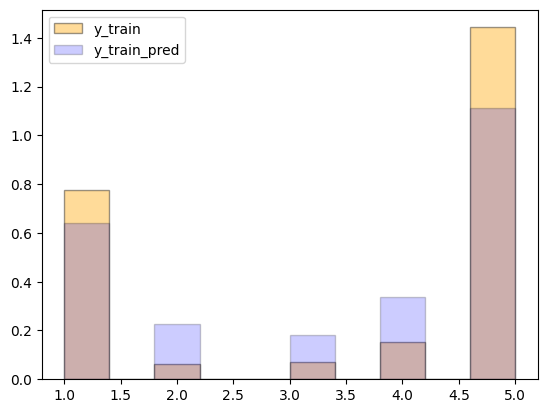

In [ ]:
plt.hist(y_train, label = 'y_train', density = True, color = 'orange',
           edgecolor = 'black', alpha = 0.4)
plt.hist(y_train_pred, label = 'y_train_pred',
           density = True, color = 'blue', edgecolor = 'black', alpha = 0.2)
plt.legend()

<font color = 'blue'>
Computing the accuracy and the F1 score.

In [ ]:
accuracy_score(y_train, y_train_pred)

0.52

In [ ]:
getF1Score(y_train, y_train_pred)

F1 score for rating 1, 0.761344537815126
F1 score for rating 2, 0.0
F1 score for rating 3, 0.09433962264150944
F1 score for rating 4, 0.07804878048780488
F1 score for rating 5, 0.5710293432696786
Mean F1 score 0.3009524568428238


<font color = 'blue'>
KMeans clustering doesn't have many hyper-paramters for fine-tuning, and hence, we will leave it here. The above scores show that the method achieved an accuracy of 0.52 and a mean F1 score of 0.30, both short of what the NMF method achieved.

## DBscan clustering

In [ ]:
from sklearn.cluster import DBSCAN

In [ ]:
# Creating the model
dbcl = DBSCAN(eps=0.8, min_samples=3).fit(X_train)
y_train_pred = dbcl.labels_

<font color = 'blue'>
Below, we count the number of values in eacg of the clusters identitfied by BD Scan. We tried different values of eps and min_samples in the above model and never found a result that gave a well enough number of clusters, which we could use for predictions.

In [ ]:
from collections import Counter

unique_counts = Counter(y_train_pred)
unique_counts


Counter({np.int64(-1): 2061,
         np.int64(0): 9,
         np.int64(4): 3,
         np.int64(1): 4,
         np.int64(2): 3,
         np.int64(3): 4,
         np.int64(5): 3,
         np.int64(8): 3,
         np.int64(6): 5,
         np.int64(7): 5})

<font color = 'blue'>
Despite many efforts with manual tuning of the hyper-parameters of DBScan clustering, I didn't see any stable result, and thus, I have not proceeded further with any analysis using DBScan.

## Agglomerative Clustering

<font color = 'blue'>
The next method we use is a heirarichal clustering method, called agglomerative clustering. It works in a bottom up approach by starting up with single nodes and systematically forming bigger clusters.

In [ ]:
# Creating the model
agcl = AgglomerativeClustering(n_clusters= 5, linkage = 'single').fit(X_train)

In [ ]:
y_train_pred = agcl.labels_

In [ ]:
# Correcting the labels of the predicted values, discussed earlier.
tag = gettag(y_train, y_train_pred)
y_train_pred = np.vectorize(lambda x: tag[x - 1])(y_train_pred)

<font color = 'blue'>
Checking the distribution of predicted values overlayed on the true values.<br>
The plot below indicates that the model isn't able to predict anything except the rating 5, which we confirm with F1 scores later. <br>

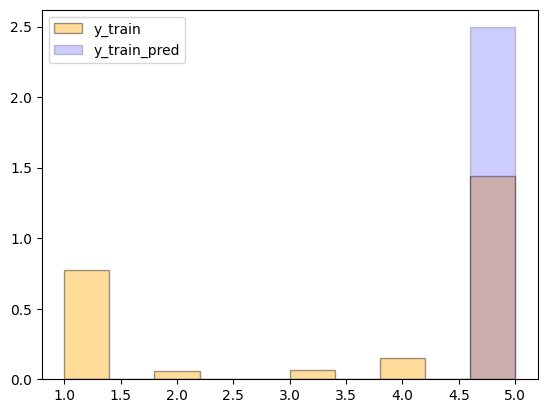

In [ ]:
plt.hist(y_train, label = 'y_train', density = True, color = 'orange',
           edgecolor = 'black', alpha = 0.4)
plt.hist(y_train_pred, label = 'y_train_pred',
           density = True, color = 'blue', edgecolor = 'black', alpha = 0.2)
plt.legend()

<font color = 'blue'>
Computing the accuracies and the F1 scores.

In [ ]:
accuracy_score(y_train, y_train_pred)

0.5780952380952381

In [ ]:
getF1Score(y_train, y_train_pred)

F1 score for rating 1, 0.003067484662576687
F1 score for rating 2, 0.038461538461538464
F1 score for rating 3, 0.0
F1 score for rating 4, 0.0
F1 score for rating 5, 0.7327690447400241
Mean F1 score 0.15485961357282785


<font color = 'blue'>
A low F1 socre confrims the highly skewed distribution of the predicted values we saw earlier.

### Hyper-parameter tuning for the agglomerative clustering model.

<font color = 'blue'>
Next, we tune the hyper-parameters of the agglomerative clustering. We tune the linkage and metric hyper-parameters. Linkage provides a way to measure the closest clusters, while metrics tells us the method of distance measurement.

In [ ]:
# the grid of values to try.
linkage = ['single', 'complete', 'average']
metric = ['euclidean', 'manhattan']
combs = list(itr.product(linkage, metric))
combs.append(('ward', 'euclidean'))
accuracy = []
f1score = []

for c in combs:
  # Creating the model and predicting values.
  agcl = AgglomerativeClustering(n_clusters= 5, linkage = c[0], metric= c[1]).fit(X_train)
  y_train_pred = agcl.labels_
  # Correcting the labels of the predicted values, discussed earlier.
  tag = gettag(y_train, y_train_pred)
  y_train_pred = np.vectorize(lambda x: tag[x - 1])(y_train_pred)
  # Computing the scores.
  accuracy.append(accuracy_score(y_train, y_train_pred))
  f1score.append(f1_score(y_train, y_train_pred, average = 'macro'))
  print(np.round(accuracy[-1], 3), np.round(f1score[-1], 3), c)

0.578 0.155 ('single', 'euclidean')
0.578 0.147 ('single', 'manhattan')
0.564 0.256 ('complete', 'euclidean')
0.579 0.155 ('complete', 'manhattan')
0.577 0.157 ('average', 'euclidean')
0.578 0.147 ('average', 'manhattan')
0.597 0.28 ('ward', 'euclidean')


<font color = 'blue'>
Below, we put all the above results from the hyper-parameter tuning of the agglomerative clustering.
</font>
<table>
  <tr>
    <th>Linkage</th>
    <th>Metric</th>
    <th>Accuracy</th>
    <th>F1 score</th>
  </tr>
    <tr>
    <td>Single</td>
    <td>Eucledian</td>
    <td>0.578</td>
    <td>0.155</td>
  </tr>
  <tr>
    <td>Single</td>
    <td>manhattan</td>
    <td>0.578</td>
    <td>0.147</td>
  </tr>
  <tr>
    <td>Complete</td>
    <td>Eucledian</td>
    <td>0.564</td>
    <td>0.256</td>
  </tr>
  <tr>
    <td>Complete</td>
    <td>manhattan</td>
    <td>0.579</td>
    <td>0.155</td>
  </tr>
  <tr>
    <td>Average</td>
    <td>Eucledian</td>
    <td>0.577</td>
    <td>0.157</td>
  </tr>
  <tr>
    <td>Average</td>
    <td>manhattan</td>
    <td>0.578</td>
    <td>0.147</td>
  </tr>
  <tr>
    <td>Ward</td>
    <td>Eucledian</td>
    <td>0.597</td>
    <td>0.28</td>
  </tr>
</table>

<font color = 'blue'>
We can see that linkage 'ward' along with the metric 'euclidean' performs the best. However, the above results also show that the agglomeratove clustering for any of the linkages and the metrics does not perform as good as the NMF method discussed above.

## Support vector Machine for a baseline result

In [ ]:
from sklearn import svm

# Creating a model for the support vector machine.
svmclf=svm.SVC()
svmclf.fit(X_train,y_train)

SVC()

<font color = 'blue'>
Making model predictions and computing the scores.

In [ ]:
y_pred = svmclf.predict(X_test)

In [ ]:
accuracy_score(y_test, y_pred)

0.8533333333333334

In [ ]:
f1_score(y_test, y_pred, average = 'macro')

0.3596835590302015

<font color = 'blue'>
I used a support vector machine classifier with default settings, and it provides a somewhat better accuracy than the NMF method, but its f1_score doesn't provide much improvement, implying that the method doesn't predict the low frequency labels well enough.

## Conclusion

<font color = 'blue'>
In this project, we tried to predict the ratings provided by employees of various companies based on the text of their reviews. We used multiple unsupervised learning models to make the predictions. We list the results from the various models below:
</font>

<table>
  <tr>
    <th>Model</th>
    <th>Accuracy</th>
    <th>F1 score</th>
  </tr>
  <tr>
    <td>NMF</td>
    <td>0.80</td>
    <td>0.37</td>
  </tr>
  <tr>
    <td>KMeans</td>
    <td>0.52</td>
    <td>0.30</td>
  </tr>
  <tr>
    <td>DBScan</td>
    <td>NA</td>
    <td>NA</td>
  </tr>
  <tr>
    <td>Agglomerative clustering</td>
    <td>0.60</td>
    <td>0.28</td>
  </tr>
  <tr>
    <td>Supervised learning - SVC</td>
    <td>0.85</td>
    <td>0.36</td>
  </tr>
</table>


<font color = 'blue'>
We saw while doing the exploratory data analysis that the ratings were highly skewed with most of them being the extreme values of 1 and 5, while the values of 2, 3, and 4 were minimal. Thus, correctly predicting only 1 and 5 ratings would give a high accuracy. Hence, because of the skewed nature of the dataset, we decided to use F1 score besides the accuracy as our metric.<br>
Based on the results of our models, we can state that none of our models did well with the intermediate ratings of 2,3, and 4, which were very low in numbers, as indicated by their low F1 scores. Moreover, hyper-parameter tuning also didn't help much with F1 score, although sometimes it helped with accuracy.<br>
Finally, we note some recommendations that we may use to further improve the prediction ability:
<ul>
<li><font color = 'blue'>We used only the TF-IFD vectorizer. There are more sophisticated vectorizers and tokenizers abvailable that may provide boost in the F1 scores.</li>
<li>There is a likelihood that our unsupervised learning methods aren't sophisticated enough for the current data, and we may need to approach more complicated deep learning methods or pretrained models on natural languages.</li>
</ul>